In [1]:
!pip install -q torchcam tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inc

In [29]:
import os
import cv2
import numpy as np
import json
import random
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from torchcam.methods import SmoothGradCAMpp
from transformers import pipeline, M2M100ForConditionalGeneration, M2M100Tokenizer
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter

In [3]:
#CONFIGURATION & DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (256, 256)
BATCH_SIZE_SEG = 4
BATCH_SIZE_CLS = 32
NUM_CLASSES_SEG = 2

In [4]:
#DATA PREPROCESSING: EgoHands → RGB + Mask pairs
SRC = "/kaggle/input/egohands/_LABELLED_SAMPLES"
DST = "/kaggle/working/processed_egohands"
os.makedirs(DST, exist_ok=True)

class_count = 0
for session in sorted(os.listdir(SRC)):
    sp = os.path.join(SRC, session)
    if not os.path.isdir(sp): continue
    mat_path = os.path.join(sp, "polygons.mat")
    if not os.path.exists(mat_path): continue

    mat = loadmat(mat_path)
    polys = mat["polygons"][0]
    frames = sorted([f for f in os.listdir(sp) if f.endswith(".jpg") and f.startswith("frame_")])
    if len(polys) != len(frames):
        print(f"Skip {session}: {len(polys)} polys vs {len(frames)} frames")
        continue

    sel = list(zip(polys, frames))[:20]
    out_dir = os.path.join(DST, f"class_{class_count:02d}")
    os.makedirs(out_dir, exist_ok=True)

    for j, (poly, fname) in enumerate(sel):
        img = cv2.imread(os.path.join(sp, fname))
        if img is None: continue
        cv2.imwrite(os.path.join(out_dir, f"img_{j:03d}.jpg"), img)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        for ann in poly:
            if ann.size == 0: continue
            pts = ann.reshape(-1,1,2).astype(np.int32)
            cv2.fillPoly(mask, [pts], 255)
        cv2.imwrite(os.path.join(out_dir, f"mask_{j:03d}.png"), mask)
    class_count += 1
    if class_count >= 50: break

print("Step 1: Preprocessing complete.")

Step 1: Preprocessing complete.


In [5]:
#Sanity Check 1: verify processed data exists
classes = [d for d in os.listdir(DST) if os.path.isdir(os.path.join(DST, d))]
assert classes, "No class directories found in processed_egohands!"
sample_cls = classes[0]
files = os.listdir(os.path.join(DST, sample_cls))
assert any(f.startswith("img_") for f in files) and any(f.startswith("mask_") for f in files), \
       f"Missing img_/mask_ files in {sample_cls}"
print(f"Preprocessing check passed: found {len(classes)} classes, samples in '{sample_cls}'")

Preprocessing check passed: found 48 classes, samples in 'class_11'


In [6]:
#SEGMENTATION DATASET
class EgoHandsSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_size=IMG_SIZE):
        self.samples = []
        # added data augmentation to prevent overfitting
        self.t_img = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        self.t_mask = transforms.Compose([
            transforms.Resize(image_size, interpolation=Image.NEAREST)
        ])
        for c in sorted(os.listdir(root_dir)):
            cp = os.path.join(root_dir, c)
            if not os.path.isdir(cp): continue
            for f in os.listdir(cp):
                if f.startswith("img_") and f.endswith(".jpg"):
                    idx = f.split("_")[1].split(".")[0]
                    m = f"mask_{idx}.png"
                    if os.path.exists(os.path.join(cp, m)):
                        self.samples.append((os.path.join(cp, f), os.path.join(cp, m)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        ip, mp = self.samples[i]
        img = Image.open(ip).convert("RGB")
        mask = Image.open(mp).convert("L")
        img = self.t_img(img)
        mask = self.t_mask(mask)
        mask = torch.from_numpy(np.array(mask)).long() // 255
        return img, mask

# prepare loaders
ds = EgoHandsSegmentationDataset(DST, IMG_SIZE)
train_n = int(0.8 * len(ds)); val_n = len(ds) - train_n
train_ds, val_ds = random_split(ds, [train_n, val_n])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE_SEG, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE_SEG, shuffle=False)

In [7]:
#Sanity Check 2: batch shapes & value ranges
imgs, msks = next(iter(train_loader))
print("Batch imgs:", imgs.shape, " masks:", msks.shape)
assert imgs.dtype == torch.float32 and msks.dtype == torch.long
assert imgs.min() >= -3 and imgs.max() <= 3, "Image normalization values out of expected range"
assert set(msks.unique().cpu().numpy()).issubset({0,1}), "Mask values not binary!"
print("DataLoader sanity check passed")

Batch imgs: torch.Size([4, 3, 256, 256])  masks: torch.Size([4, 256, 256])
DataLoader sanity check passed


In [8]:
#U-NET MODEL DEFINITION
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=NUM_CLASSES_SEG, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        for f in features:
            self.downs.append(self._conv_block(in_channels, f))
            in_channels = f
        self.pool = nn.MaxPool2d(2,2)
        self.bottleneck = self._conv_block(features[-1], features[-1]*2)
        # added dropout in bottleneck for regularization
        self.dropout = nn.Dropout2d(0.3)
        self.ups = nn.ModuleList()
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, 2, 2))
            self.ups.append(self._conv_block(f*2, f))
        self.final = nn.Conv2d(features[0], num_classes, 1)

    def forward(self, x):
        skips=[]
        for down in self.downs:
            x = down(x); skips.append(x); x = self.pool(x)
        x = self.bottleneck(x)
        x = self.dropout(x)
        skips = skips[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skips[idx//2]
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)
        return self.final(x)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),  # added spatial dropout
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

In [9]:
#SEGMENTATION TRAINING LOOP
model_seg = UNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
# added weight decay for regularization
optimizer = optim.Adam(model_seg.parameters(), lr=1e-4, weight_decay=1e-5)

# pre-forward sanity check
model_seg.train()
out = model_seg(imgs.to(DEVICE))
print("Forward output shape:", out.shape)
assert out.shape[1] == NUM_CLASSES_SEG, "Output channel mismatch!"
print("Forward pass sanity check passed")

seg_train_losses, seg_val_losses = [], []
seg_train_accs, seg_val_accs = [], []
seg_train_aucs, seg_val_aucs = [], []

for ep in range(1, 51):
    model_seg.train()
    tl, correct_pix, total_pix = 0.0, 0, 0
    for imgs_b, msks_b in train_loader:
        imgs_b, msks_b = imgs_b.to(DEVICE), msks_b.to(DEVICE)
        optimizer.zero_grad()
        out_b = model_seg(imgs_b)
        loss = criterion(out_b, msks_b)
        loss.backward()
        optimizer.step()
        tl += loss.item()
        preds = out_b.argmax(1)
        correct_pix += (preds == msks_b).sum().item()
        total_pix += msks_b.numel()
    train_loss = tl / len(train_loader)
    train_acc  = correct_pix / total_pix
    seg_train_losses.append(train_loss)
    seg_train_accs.append(train_acc)

    model_seg.eval()
    vl, val_correct, val_total = 0.0, 0, 0
    all_probs, all_labels_flat = [], []
    with torch.no_grad():
        for imgs_b, msks_b in val_loader:
            imgs_b, msks_b = imgs_b.to(DEVICE), msks_b.to(DEVICE)
            out_val = model_seg(imgs_b)
            vl += criterion(out_val, msks_b).item()
            preds_v = out_val.argmax(1)
            val_correct += (preds_v == msks_b).sum().item()
            val_total += msks_b.numel()
            probs = torch.softmax(out_val, dim=1)[:,1,:,:].cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels_flat.extend(msks_b.cpu().numpy().flatten())
    val_loss = vl / len(val_loader)
    val_acc  = val_correct / val_total
    val_auc  = roc_auc_score(all_labels_flat, all_probs)
    seg_val_losses.append(val_loss)
    seg_val_accs.append(val_acc)
    seg_val_aucs.append(val_auc)

    print(f"Epoch {ep}/50 — Seg Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}  "
          f"Seg Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

# save segmentation model
torch.save(model_seg.state_dict(), "/kaggle/working/unet_egohands.pth")

Forward output shape: torch.Size([4, 2, 256, 256])
Forward pass sanity check passed
Epoch 1/50 — Seg Train Loss: 0.3529 Acc: 0.9023  Seg Val Loss: 0.2557 Acc: 0.9327 AUC: 0.7732
Epoch 2/50 — Seg Train Loss: 0.2479 Acc: 0.9243  Seg Val Loss: 0.2261 Acc: 0.9273 AUC: 0.8170
Epoch 3/50 — Seg Train Loss: 0.2264 Acc: 0.9243  Seg Val Loss: 0.2009 Acc: 0.9339 AUC: 0.8481
Epoch 4/50 — Seg Train Loss: 0.2142 Acc: 0.9249  Seg Val Loss: 0.1979 Acc: 0.9325 AUC: 0.8453
Epoch 5/50 — Seg Train Loss: 0.2091 Acc: 0.9251  Seg Val Loss: 0.2034 Acc: 0.9317 AUC: 0.8381
Epoch 6/50 — Seg Train Loss: 0.2068 Acc: 0.9254  Seg Val Loss: 0.1874 Acc: 0.9335 AUC: 0.8546
Epoch 7/50 — Seg Train Loss: 0.2019 Acc: 0.9252  Seg Val Loss: 0.1806 Acc: 0.9354 AUC: 0.8664
Epoch 8/50 — Seg Train Loss: 0.1965 Acc: 0.9268  Seg Val Loss: 0.1811 Acc: 0.9343 AUC: 0.8690
Epoch 9/50 — Seg Train Loss: 0.1953 Acc: 0.9272  Seg Val Loss: 0.1762 Acc: 0.9368 AUC: 0.8821
Epoch 10/50 — Seg Train Loss: 0.1945 Acc: 0.9275  Seg Val Loss: 0.1774

In [10]:
#Sanity Check 3: reload & compare forward outputs
model_seg.eval()
with torch.no_grad():
    reference_out = model_seg(imgs.to(DEVICE))   # output from the trained model

# Now load into a fresh model and compare
m2 = UNet().to(DEVICE)
# load only weights to suppress the pickle warning
state_dict = torch.load("/kaggle/working/unet_egohands.pth", weights_only=True)
m2.load_state_dict(state_dict)
m2.eval()

with torch.no_grad():
    loaded_out = m2(imgs.to(DEVICE))

# These should now be identical
assert torch.allclose(reference_out, loaded_out, atol=1e-5), "Model mismatch after loading!"
print("Model save/load sanity check passed")

Model save/load sanity check passed


In [11]:
#Segmentation Classification Report
model_seg.eval()
all_preds_seg, all_labels_seg = [], []
with torch.no_grad():
    for imgs_b, msks_b in val_loader:
        out_b = model_seg(imgs_b.to(DEVICE)).argmax(1).cpu().numpy().flatten()
        lbls = msks_b.numpy().flatten()
        all_preds_seg.extend(out_b)
        all_labels_seg.extend(lbls)
print("\nSegmentation Classification Report:")
print(classification_report(all_labels_seg, all_preds_seg, labels=[0,1], target_names=["background","hand"]))


Segmentation Classification Report:
              precision    recall  f1-score   support

  background       0.97      0.97      0.97  11741280
        hand       0.58      0.53      0.56    841632

    accuracy                           0.94  12582912
   macro avg       0.77      0.75      0.76  12582912
weighted avg       0.94      0.94      0.94  12582912



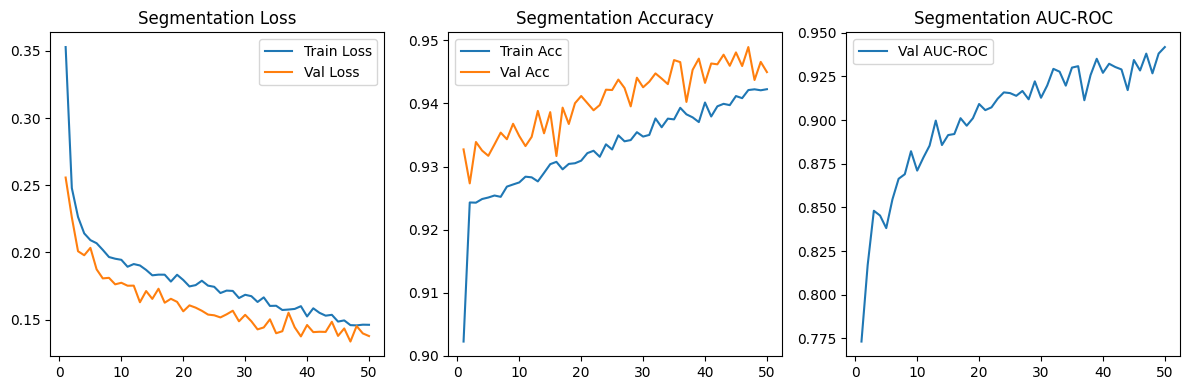

In [12]:
# plot segmentation metrics
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(range(1,51), seg_train_losses, label="Train Loss")
plt.plot(range(1,51), seg_val_losses,   label="Val Loss")
plt.title("Segmentation Loss"); plt.legend()
plt.subplot(1,3,2)
plt.plot(range(1,51), seg_train_accs, label="Train Acc")
plt.plot(range(1,51), seg_val_accs,   label="Val Acc")
plt.title("Segmentation Accuracy"); plt.legend()
plt.subplot(1,3,3)
plt.plot(range(1,51), seg_val_aucs, label="Val AUC-ROC")
plt.title("Segmentation AUC-ROC"); plt.legend()
plt.tight_layout(); plt.show()

In [13]:
#VIDEO SEGMENTATION WITH U-NET
VIDEO_ROOT = "/kaggle/input/wlasl-processed/videos"
JSON_PATH  = "/kaggle/input/wlasl-processed/WLASL_v0.3.json"
OUT_ROOT   = "/kaggle/working/wlasl_segmented_unet"
os.makedirs(OUT_ROOT, exist_ok=True)

with open(JSON_PATH,'r') as f:
    data = json.load(f)

# Use exactly this set of glosses
selected_glosses = [
    "action", "alligator", "alone", "amputate", "angel", "benefit",
    "bird", "bracelet", "candy", "chapter", "cheese", "contact",
    "crazy", "cute", "december", "desert", "drama", "drive", "fear",
    "festival", "her", "high school", "highway", "inform", "listen",
    "mosquito", "open", "opposite", "paper", "pregnant", "relax",
    "remove", "ring", "schedule", "sculpture", "shock", "shovel",
    "speech", "thank you", "tomorrow", "willing"
]
print(f"Using fixed set of {len(selected_glosses)} glosses.")

# Build video→gloss map
vid2gloss = {}
for entry in data:
    gloss = entry["gloss"]
    if gloss not in selected_glosses:
        continue
    for inst in entry["instances"]:
        vid2gloss[inst["video_id"]] = gloss

model_seg.load_state_dict(torch.load("/kaggle/working/unet_egohands.pth", map_location=DEVICE))
model_seg.eval().to(DEVICE)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

for vf in tqdm(sorted(os.listdir(VIDEO_ROOT))):
    if not vf.endswith(".mp4"):
        continue
    vid   = vf[:-4]
    gloss = vid2gloss.get(vid)
    if gloss is None:
        continue

    od = os.path.join(OUT_ROOT, gloss)
    os.makedirs(od, exist_ok=True)
    cap = cv2.VideoCapture(os.path.join(VIDEO_ROOT, vf))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(int(0.2 * total_frames), int(0.8 * total_frames), 20).astype(int)

    cnt = 0
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue

        # 1) Convert & resize the RGB frame to 256×256
        rgb_full     = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_resized  = Image.fromarray(rgb_full).resize(IMG_SIZE)
        rgb_resized  = np.array(pil_resized)                     # shape (256,256,3)

        # 2) Predict mask
        inp   = tfm(pil_resized).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            mask = model_seg(inp).argmax(1)[0].cpu().numpy()     # shape (256,256)

        # 3) Ensure uint8 mask (0 or 1)
        mask_uint8 = (mask == 1).astype(np.uint8)

        # 4) Apply mask to the resized image
        hand = cv2.bitwise_and(rgb_resized, rgb_resized, mask=mask_uint8)

        # 5) Save result (BGR back for disk)
        out_path = os.path.join(od, f"{vid}_frame_{cnt:02d}.jpg")
        cv2.imwrite(out_path, cv2.cvtColor(hand, cv2.COLOR_RGB2BGR))
        cnt += 1

    cap.release()

    # Sanity check
    saved = os.listdir(od)
    assert saved, f"No segmented frames saved for gloss {gloss}"
    print(f"{len(saved)} segmented frames for '{gloss}'")

Using fixed set of 41 glosses.


/tmp/ipykernel_31/995638920.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_seg.load_state_dict(torch.load("/kaggle/working/unet_egohands.pth", map_location=DEVIC

20 segmented frames for 'action'
40 segmented frames for 'action'
60 segmented frames for 'action'
80 segmented frames for 'action'


  1%|          | 72/11980 [00:03<10:48, 18.37it/s] 

100 segmented frames for 'action'


  2%|▏         | 259/11980 [00:03<02:10, 89.67it/s]

20 segmented frames for 'alligator'
40 segmented frames for 'alligator'
60 segmented frames for 'alligator'
80 segmented frames for 'alligator'
100 segmented frames for 'alligator'
20 segmented frames for 'alone'
40 segmented frames for 'alone'
60 segmented frames for 'alone'
80 segmented frames for 'alone'
100 segmented frames for 'alone'
120 segmented frames for 'alone'
140 segmented frames for 'alone'


  2%|▏         | 281/11980 [00:15<15:02, 12.96it/s]

160 segmented frames for 'alone'


  3%|▎         | 319/11980 [00:16<12:09, 15.99it/s]

20 segmented frames for 'amputate'
40 segmented frames for 'amputate'
60 segmented frames for 'amputate'
80 segmented frames for 'amputate'


  3%|▎         | 335/11980 [00:19<16:03, 12.09it/s]

100 segmented frames for 'amputate'
20 segmented frames for 'angel'
40 segmented frames for 'angel'
60 segmented frames for 'angel'
80 segmented frames for 'angel'
100 segmented frames for 'angel'


  3%|▎         | 346/11980 [00:24<24:03,  8.06it/s]

120 segmented frames for 'angel'


  8%|▊         | 969/11980 [00:25<02:26, 75.02it/s]

20 segmented frames for 'benefit'
40 segmented frames for 'benefit'
60 segmented frames for 'benefit'
80 segmented frames for 'benefit'
100 segmented frames for 'benefit'


  9%|▊         | 1028/11980 [00:28<03:07, 58.53it/s]

120 segmented frames for 'benefit'
20 segmented frames for 'bird'
40 segmented frames for 'bird'
60 segmented frames for 'bird'
80 segmented frames for 'bird'
100 segmented frames for 'bird'
120 segmented frames for 'bird'
140 segmented frames for 'bird'


  9%|▉         | 1069/11980 [00:35<05:51, 31.01it/s]

160 segmented frames for 'bird'


 10%|█         | 1228/11980 [00:35<03:57, 45.36it/s]

20 segmented frames for 'bracelet'
40 segmented frames for 'bracelet'
60 segmented frames for 'bracelet'
80 segmented frames for 'bracelet'
100 segmented frames for 'bracelet'


 11%|█         | 1258/11980 [00:41<06:47, 26.33it/s]

120 segmented frames for 'bracelet'


 13%|█▎        | 1522/11980 [00:42<03:20, 52.10it/s]

20 segmented frames for 'candy'
40 segmented frames for 'candy'
60 segmented frames for 'candy'
80 segmented frames for 'candy'
100 segmented frames for 'candy'
120 segmented frames for 'candy'
140 segmented frames for 'candy'
160 segmented frames for 'candy'
180 segmented frames for 'candy'


 13%|█▎        | 1553/11980 [00:55<08:45, 19.86it/s]

200 segmented frames for 'candy'


 14%|█▍        | 1717/11980 [00:55<05:31, 30.98it/s]

20 segmented frames for 'chapter'
40 segmented frames for 'chapter'
60 segmented frames for 'chapter'


 15%|█▍        | 1751/11980 [00:57<05:57, 28.60it/s]

80 segmented frames for 'chapter'
20 segmented frames for 'cheese'
40 segmented frames for 'cheese'
60 segmented frames for 'cheese'
80 segmented frames for 'cheese'
100 segmented frames for 'cheese'


 15%|█▍        | 1776/11980 [01:03<09:06, 18.68it/s]

120 segmented frames for 'cheese'


 18%|█▊        | 2200/11980 [01:03<02:45, 59.06it/s]

20 segmented frames for 'contact'
40 segmented frames for 'contact'
60 segmented frames for 'contact'
80 segmented frames for 'contact'
100 segmented frames for 'contact'
120 segmented frames for 'contact'


 19%|█▊        | 2239/11980 [01:08<04:08, 39.17it/s]

140 segmented frames for 'contact'


 20%|██        | 2406/11980 [01:08<02:50, 56.08it/s]

20 segmented frames for 'crazy'
40 segmented frames for 'crazy'
60 segmented frames for 'crazy'
80 segmented frames for 'crazy'


 20%|██        | 2436/11980 [01:11<03:40, 43.38it/s]

100 segmented frames for 'crazy'


 21%|██        | 2477/11980 [01:11<03:24, 46.42it/s]

20 segmented frames for 'cute'
40 segmented frames for 'cute'
60 segmented frames for 'cute'
80 segmented frames for 'cute'
100 segmented frames for 'cute'
120 segmented frames for 'cute'


 21%|██        | 2495/11980 [01:17<06:45, 23.40it/s]

140 segmented frames for 'cute'


 22%|██▏       | 2585/11980 [01:17<04:35, 34.16it/s]

20 segmented frames for 'december'
40 segmented frames for 'december'
60 segmented frames for 'december'
80 segmented frames for 'december'


 22%|██▏       | 2600/11980 [01:20<06:52, 22.74it/s]

100 segmented frames for 'december'


 23%|██▎       | 2728/11980 [01:21<03:45, 40.97it/s]

20 segmented frames for 'desert'
40 segmented frames for 'desert'
60 segmented frames for 'desert'
80 segmented frames for 'desert'
100 segmented frames for 'desert'


 23%|██▎       | 2743/11980 [01:26<07:09, 21.51it/s]

120 segmented frames for 'desert'


 25%|██▌       | 3053/11980 [01:26<02:15, 65.69it/s]

20 segmented frames for 'drama'
40 segmented frames for 'drama'
60 segmented frames for 'drama'
80 segmented frames for 'drama'


 26%|██▌       | 3085/11980 [01:30<03:55, 37.78it/s]

100 segmented frames for 'drama'
20 segmented frames for 'drive'
40 segmented frames for 'drive'
60 segmented frames for 'drive'
80 segmented frames for 'drive'
100 segmented frames for 'drive'


 26%|██▌       | 3108/11980 [01:37<07:02, 21.00it/s]

120 segmented frames for 'drive'


 31%|███       | 3704/11980 [01:37<01:38, 83.97it/s]

20 segmented frames for 'fear'
40 segmented frames for 'fear'
60 segmented frames for 'fear'
80 segmented frames for 'fear'
100 segmented frames for 'fear'
20 segmented frames for 'festival'
40 segmented frames for 'festival'
60 segmented frames for 'festival'


 31%|███▏      | 3754/11980 [01:42<02:36, 52.61it/s]

80 segmented frames for 'festival'


 39%|███▊      | 4620/11980 [01:42<00:48, 152.84it/s]

20 segmented frames for 'her'
40 segmented frames for 'her'
60 segmented frames for 'her'
80 segmented frames for 'her'
100 segmented frames for 'her'
120 segmented frames for 'her'
140 segmented frames for 'her'
160 segmented frames for 'her'
20 segmented frames for 'high school'
40 segmented frames for 'high school'
60 segmented frames for 'high school'
80 segmented frames for 'high school'
20 segmented frames for 'highway'
40 segmented frames for 'highway'
60 segmented frames for 'highway'
80 segmented frames for 'highway'
100 segmented frames for 'highway'
120 segmented frames for 'highway'


 39%|███▉      | 4702/11980 [01:54<02:08, 56.85it/s] 

140 segmented frames for 'highway'


 41%|████      | 4939/11980 [01:54<01:35, 73.53it/s]

20 segmented frames for 'inform'
40 segmented frames for 'inform'
60 segmented frames for 'inform'
80 segmented frames for 'inform'
100 segmented frames for 'inform'
120 segmented frames for 'inform'
140 segmented frames for 'inform'


 42%|████▏     | 5011/11980 [02:01<02:27, 47.25it/s]

160 segmented frames for 'inform'


 46%|████▌     | 5540/11980 [02:01<01:09, 92.27it/s]

20 segmented frames for 'listen'
40 segmented frames for 'listen'
60 segmented frames for 'listen'
80 segmented frames for 'listen'
100 segmented frames for 'listen'
120 segmented frames for 'listen'


 47%|████▋     | 5605/11980 [02:07<01:55, 55.25it/s]

140 segmented frames for 'listen'


 50%|████▉     | 5976/11980 [02:10<01:20, 74.87it/s]

20 segmented frames for 'mosquito'
40 segmented frames for 'mosquito'
60 segmented frames for 'mosquito'


 50%|█████     | 6013/11980 [02:12<01:33, 63.77it/s]

80 segmented frames for 'mosquito'


 54%|█████▍    | 6458/11980 [02:12<00:47, 116.22it/s]

20 segmented frames for 'open'
40 segmented frames for 'open'
60 segmented frames for 'open'
80 segmented frames for 'open'
100 segmented frames for 'open'
120 segmented frames for 'open'
140 segmented frames for 'open'
20 segmented frames for 'opposite'
40 segmented frames for 'opposite'
60 segmented frames for 'opposite'
80 segmented frames for 'opposite'


 54%|█████▍    | 6507/11980 [02:21<01:55, 47.37it/s] 

100 segmented frames for 'opposite'


 55%|█████▌    | 6595/11980 [02:22<01:40, 53.56it/s]

20 segmented frames for 'paper'
40 segmented frames for 'paper'
60 segmented frames for 'paper'
80 segmented frames for 'paper'
100 segmented frames for 'paper'
120 segmented frames for 'paper'
140 segmented frames for 'paper'


 55%|█████▌    | 6625/11980 [02:28<02:48, 31.86it/s]

160 segmented frames for 'paper'


 59%|█████▉    | 7112/11980 [02:28<01:01, 79.24it/s]

20 segmented frames for 'pregnant'
40 segmented frames for 'pregnant'
60 segmented frames for 'pregnant'
80 segmented frames for 'pregnant'


 60%|█████▉    | 7158/11980 [02:33<01:30, 53.46it/s]

100 segmented frames for 'pregnant'


 64%|██████▎   | 7608/11980 [02:33<00:42, 104.02it/s]

20 segmented frames for 'relax'
40 segmented frames for 'relax'
60 segmented frames for 'relax'
80 segmented frames for 'relax'
20 segmented frames for 'remove'
40 segmented frames for 'remove'
60 segmented frames for 'remove'
80 segmented frames for 'remove'
100 segmented frames for 'remove'


 64%|██████▍   | 7657/11980 [02:42<01:36, 44.95it/s] 

120 segmented frames for 'remove'


 65%|██████▌   | 7798/11980 [02:42<01:14, 55.94it/s]

20 segmented frames for 'ring'
40 segmented frames for 'ring'
60 segmented frames for 'ring'
80 segmented frames for 'ring'


 65%|██████▌   | 7831/11980 [02:47<01:46, 39.01it/s]

100 segmented frames for 'ring'


 67%|██████▋   | 8018/11980 [02:47<01:08, 57.95it/s]

20 segmented frames for 'schedule'
40 segmented frames for 'schedule'
60 segmented frames for 'schedule'
80 segmented frames for 'schedule'


 67%|██████▋   | 8044/11980 [02:51<01:38, 39.99it/s]

100 segmented frames for 'schedule'


 67%|██████▋   | 8078/11980 [02:51<01:33, 41.55it/s]

20 segmented frames for 'sculpture'
40 segmented frames for 'sculpture'
60 segmented frames for 'sculpture'
80 segmented frames for 'sculpture'
100 segmented frames for 'sculpture'


 68%|██████▊   | 8093/11980 [02:55<02:42, 23.92it/s]

120 segmented frames for 'sculpture'


 69%|██████▉   | 8269/11980 [02:56<01:18, 47.26it/s]

20 segmented frames for 'shock'
40 segmented frames for 'shock'
60 segmented frames for 'shock'
80 segmented frames for 'shock'
100 segmented frames for 'shock'
120 segmented frames for 'shock'
140 segmented frames for 'shock'


 69%|██████▉   | 8288/11980 [03:05<03:28, 17.71it/s]

160 segmented frames for 'shock'


 69%|██████▉   | 8320/11980 [03:06<03:10, 19.18it/s]

20 segmented frames for 'shovel'
40 segmented frames for 'shovel'


 70%|██████▉   | 8331/11980 [03:07<03:22, 18.04it/s]

60 segmented frames for 'shovel'


 73%|███████▎  | 8777/11980 [03:08<00:37, 86.24it/s]

20 segmented frames for 'speech'
40 segmented frames for 'speech'
60 segmented frames for 'speech'
80 segmented frames for 'speech'
100 segmented frames for 'speech'
120 segmented frames for 'speech'
140 segmented frames for 'speech'
160 segmented frames for 'speech'
180 segmented frames for 'speech'


 74%|███████▎  | 8821/11980 [03:18<01:50, 28.54it/s]

200 segmented frames for 'speech'


 79%|███████▉  | 9512/11980 [03:22<00:34, 71.65it/s]

20 segmented frames for 'thank you'
40 segmented frames for 'thank you'
60 segmented frames for 'thank you'
80 segmented frames for 'thank you'


 80%|███████▉  | 9549/11980 [03:24<00:40, 59.30it/s]

100 segmented frames for 'thank you'


 81%|████████▏ | 9761/11980 [03:25<00:27, 79.62it/s]

20 segmented frames for 'tomorrow'
40 segmented frames for 'tomorrow'
60 segmented frames for 'tomorrow'
80 segmented frames for 'tomorrow'
100 segmented frames for 'tomorrow'


 82%|████████▏ | 9794/11980 [03:31<00:50, 43.17it/s]

120 segmented frames for 'tomorrow'


 88%|████████▊ | 10483/11980 [03:31<00:13, 114.62it/s]

20 segmented frames for 'willing'
40 segmented frames for 'willing'
60 segmented frames for 'willing'
80 segmented frames for 'willing'


 88%|████████▊ | 10537/11980 [03:34<00:16, 90.06it/s] 

100 segmented frames for 'willing'


 89%|████████▉ | 10722/11980 [03:34<00:11, 107.86it/s]

120 segmented frames for 'action'
180 segmented frames for 'alone'


 90%|████████▉ | 10757/11980 [03:36<00:13, 92.29it/s] 

140 segmented frames for 'angel'


 90%|█████████ | 10832/11980 [03:36<00:11, 96.74it/s]

140 segmented frames for 'benefit'


 91%|█████████ | 10854/11980 [03:37<00:12, 87.63it/s]

180 segmented frames for 'bird'


 91%|█████████ | 10871/11980 [03:37<00:14, 78.85it/s]

140 segmented frames for 'bracelet'


 91%|█████████ | 10903/11980 [03:38<00:14, 74.35it/s]

220 segmented frames for 'candy'
240 segmented frames for 'candy'


 91%|█████████ | 10914/11980 [03:39<00:21, 50.48it/s]

260 segmented frames for 'candy'


 91%|█████████▏| 10939/11980 [03:40<00:21, 48.88it/s]

140 segmented frames for 'cheese'


 92%|█████████▏| 10990/11980 [03:40<00:17, 56.32it/s]

120 segmented frames for 'crazy'


 92%|█████████▏| 10997/11980 [03:41<00:22, 44.12it/s]

140 segmented frames for 'crazy'


 92%|█████████▏| 11021/11980 [03:42<00:23, 41.54it/s]

140 segmented frames for 'desert'


 92%|█████████▏| 11063/11980 [03:42<00:18, 50.23it/s]

140 segmented frames for 'drive'


 94%|█████████▍| 11262/11980 [03:43<00:05, 130.68it/s]

180 segmented frames for 'inform'


 96%|█████████▌| 11503/11980 [03:43<00:02, 211.48it/s]

140 segmented frames for 'remove'


 96%|█████████▋| 11547/11980 [03:44<00:02, 174.39it/s]

180 segmented frames for 'shock'


 97%|█████████▋| 11628/11980 [03:44<00:02, 165.42it/s]

120 segmented frames for 'thank you'


 97%|█████████▋| 11657/11980 [03:45<00:02, 130.14it/s]

140 segmented frames for 'tomorrow'


 98%|█████████▊| 11733/11980 [03:46<00:01, 133.08it/s]

120 segmented frames for 'willing'


 98%|█████████▊| 11780/11980 [03:49<00:04, 44.69it/s] 

200 segmented frames for 'bird'


 99%|█████████▊| 11802/11980 [03:51<00:05, 31.93it/s]

100 segmented frames for 'chapter'


100%|██████████| 11980/11980 [03:53<00:00, 51.24it/s]

140 segmented frames for 'thank you'


In [14]:
#CLASSIFIER TRAINING ON SEGMENTED FRAMES
# Remove any empty class directories so ImageFolder won’t choke
for class_name in sorted(os.listdir(OUT_ROOT)):
    class_path = os.path.join(OUT_ROOT, class_name)
    if not os.path.isdir(class_path):
        continue
    has_image = any(
        fname.lower().endswith((".jpg", ".jpeg", ".png"))
        for fname in os.listdir(class_path)
    )
    if not has_image:
        print(f"🗑  Removing empty class dir: {class_name}")
        os.rmdir(class_path)

# Now load with ImageFolder + augmentation
cls_ds = datasets.ImageFolder(
    OUT_ROOT,
    transform=transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
)
num_classes = len(cls_ds.classes)
print(f"Loaded {len(cls_ds)} images across {num_classes} classes")

Loaded 5360 images across 41 classes


In [15]:
#Sanity Check 5: class distribution
labels = [lab for _, lab in cls_ds.samples]
dist = Counter(labels)
print("Class distribution (first 5):", dist.most_common(5))
assert len(dist) == num_classes, "Detected class count mismatch!"

Class distribution (first 5): [(8, 260), (6, 200), (37, 200), (2, 180), (23, 180)]


In [16]:
t_n = int(0.8 * len(cls_ds)); v_n = len(cls_ds) - t_n
train_cls, val_cls = random_split(cls_ds, [t_n, v_n])
train_loader = DataLoader(train_cls, batch_size=BATCH_SIZE_CLS, shuffle=True)
val_loader   = DataLoader(val_cls,   batch_size=BATCH_SIZE_CLS, shuffle=False)

In [17]:
model_cls = models.resnet18(pretrained=True)
# add dropout before final layer to regularize
model_cls.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model_cls.fc.in_features, num_classes)
)
model_cls = model_cls.to(DEVICE)
crit_cls = nn.CrossEntropyLoss()
opt_cls  = optim.Adam(model_cls.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.2MB/s]


In [18]:
cls_train_losses, cls_val_losses = [], []
cls_train_accs, cls_val_accs = [], []
cls_val_aucs = []

for ep in range(1, 51):
    model_cls.train()
    r_loss, corr, tot = 0.0, 0, 0
    for imgs_b, labs_b in train_loader:
        imgs_b, labs_b = imgs_b.to(DEVICE), labs_b.to(DEVICE)
        opt_cls.zero_grad()
        out_b = model_cls(imgs_b)
        loss = crit_cls(out_b, labs_b)
        loss.backward()
        opt_cls.step()
        r_loss += loss.item()
        preds = out_b.argmax(1)
        corr += (preds == labs_b).sum().item()
        tot  += labs_b.size(0)
    train_loss = r_loss / len(train_loader)
    train_acc  = corr / tot
    cls_train_losses.append(train_loss)
    cls_train_accs.append(train_acc)

    model_cls.eval()
    v_loss, v_corr, v_tot = 0.0, 0, 0
    all_probs_clf, all_labels_clf = [], []
    with torch.no_grad():
        for imgs_b, labs_b in val_loader:
            imgs_b, labs_b = imgs_b.to(DEVICE), labs_b.to(DEVICE)
            o = model_cls(imgs_b)
            v_loss   += crit_cls(o, labs_b).item()
            probs    = torch.softmax(o, dim=1).cpu().numpy()
            all_probs_clf.extend(probs)
            all_labels_clf.extend(labs_b.cpu().numpy())
            preds_v   = o.argmax(1)
            v_corr   += (preds_v == labs_b).sum().item()
            v_tot    += labs_b.size(0)
    val_loss = v_loss / len(val_loader)
    val_acc  = v_corr / v_tot
    # multiclass AUC-ROC
    try:
        val_auc = roc_auc_score(
            np.eye(num_classes)[all_labels_clf],
            all_probs_clf,
            multi_class='ovr'
        )
    except:
        val_auc = float('nan')
    cls_val_losses.append(val_loss)
    cls_val_accs.append(val_acc)
    cls_val_aucs.append(val_auc)

    print(f"Epoch {ep}/50 | Cls Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f}")

torch.save(model_cls.state_dict(), "/kaggle/working/resnet18_wlasl.pth")

Epoch 1/50 | Cls Train Loss: 3.6930 Acc: 0.0627  Val Loss: 3.3787 Acc: 0.1259 AUC: 0.7054
Epoch 2/50 | Cls Train Loss: 3.3628 Acc: 0.1276  Val Loss: 3.0728 Acc: 0.2127 AUC: 0.7779
Epoch 3/50 | Cls Train Loss: 3.0945 Acc: 0.1868  Val Loss: 2.7993 Acc: 0.2761 AUC: 0.8268
Epoch 4/50 | Cls Train Loss: 2.8359 Acc: 0.2519  Val Loss: 2.6551 Acc: 0.3004 AUC: 0.8334
Epoch 5/50 | Cls Train Loss: 2.6345 Acc: 0.3050  Val Loss: 2.4697 Acc: 0.3563 AUC: 0.8723
Epoch 6/50 | Cls Train Loss: 2.4612 Acc: 0.3512  Val Loss: 2.3981 Acc: 0.3629 AUC: 0.8749
Epoch 7/50 | Cls Train Loss: 2.3510 Acc: 0.3820  Val Loss: 2.2120 Acc: 0.4114 AUC: 0.8942
Epoch 8/50 | Cls Train Loss: 2.2167 Acc: 0.4172  Val Loss: 2.1809 Acc: 0.4160 AUC: 0.8935
Epoch 9/50 | Cls Train Loss: 2.1087 Acc: 0.4459  Val Loss: 2.0875 Acc: 0.4543 AUC: 0.9081
Epoch 10/50 | Cls Train Loss: 2.0606 Acc: 0.4594  Val Loss: 2.0734 Acc: 0.4412 AUC: 0.9054
Epoch 11/50 | Cls Train Loss: 1.9743 Acc: 0.4785  Val Loss: 1.9777 Acc: 0.4683 AUC: 0.9122
Epoch 12

In [19]:
#Sanity Check 6: final accuracy threshold
print(f"Final Val Acc: {cls_val_accs[-1]*100:.2f}%")
assert cls_val_accs[-1] > 0.10, "Final accuracy too low!"

Final Val Acc: 59.33%


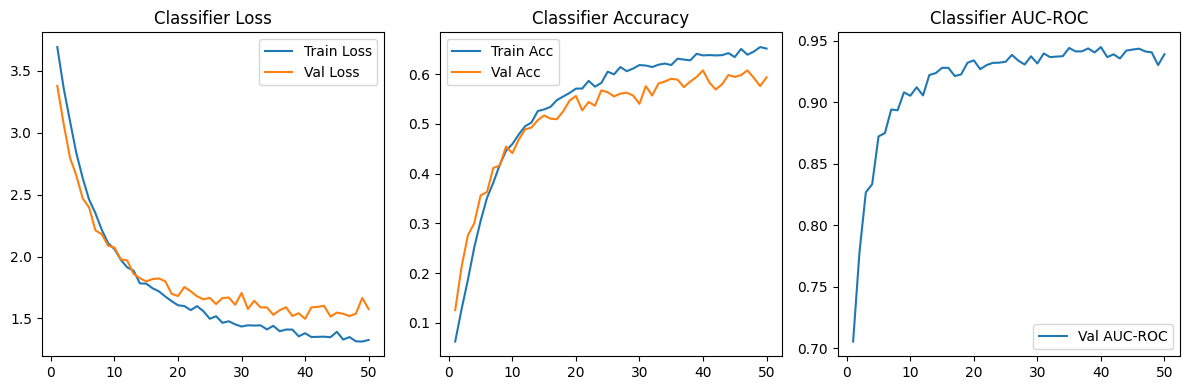

In [20]:
# plot classifier metrics
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(range(1,51), cls_train_losses, label="Train Loss")
plt.plot(range(1,51), cls_val_losses,   label="Val Loss")
plt.title("Classifier Loss"); plt.legend()
plt.subplot(1,3,2)
plt.plot(range(1,51), cls_train_accs, label="Train Acc")
plt.plot(range(1,51), cls_val_accs,   label="Val Acc")
plt.title("Classifier Accuracy"); plt.legend()
plt.subplot(1,3,3)
plt.plot(range(1,51), cls_val_aucs, label="Val AUC-ROC")
plt.title("Classifier AUC-ROC"); plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
#CLASSIFICATION REPORT & CONFUSION MATRIX
all_preds, all_labels = [], []
model_cls.eval()
with torch.no_grad():
    for imgs_b, labs_b in val_loader:
        imgs_b = imgs_b.to(DEVICE)
        out_b = model_cls(imgs_b).argmax(1).cpu().numpy()
        all_preds.extend(out_b); all_labels.extend(labs_b.numpy())

used = sorted(set(all_labels + all_preds))
cnames = [cls_ds.classes[i] for i in used]
print("\nClassifier Classification Report:")
print(classification_report(all_labels, all_preds, labels=used, target_names=cnames))
cm = confusion_matrix(all_labels, all_preds, labels=used)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=cnames, yticklabels=cnames, cmap="Blues")
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


Classifier Classification Report:
              precision    recall  f1-score   support

      action       0.88      0.84      0.86        25
   alligator       0.92      0.50      0.65        22
       alone       0.87      0.50      0.63        40
    amputate       0.92      0.80      0.86        15
       angel       0.71      0.48      0.57        25
     benefit       0.93      0.59      0.72        22
        bird       0.89      0.53      0.67        47
    bracelet       0.79      0.66      0.72        29
       candy       0.18      0.93      0.30        58
     chapter       1.00      0.83      0.91        12
      cheese       0.73      0.47      0.58        40
     contact       0.92      0.71      0.80        31
       crazy       0.81      0.61      0.69        28
        cute       0.70      0.36      0.47        39
    december       0.94      0.79      0.86        19
      desert       0.52      0.70      0.59        23
       drama       0.64      0.82      0.72   

In [ ]:
#GRAD-CAM VISUALIZATIONS
cam = SmoothGradCAMpp(model_cls, target_layer="layer4")
sample_ix = random.sample(range(len(val_cls)), 5)
plt.figure(figsize=(20, 5))

for i, idx in enumerate(sample_ix):
    # 1) Sample & forward
    img, lab = val_cls[idx]
    inp = img.unsqueeze(0).to(DEVICE)
    out_b = model_cls(inp)
    pred = out_b.argmax(1).item()
    
    # 2) Get raw CAM (may be multi-channel)
    amap = cam(pred, out_b)[0].cpu().numpy()
    # → Collapse across channels if needed
    if amap.ndim == 3:
        amap = np.mean(amap, axis=0)  # now shape (H, W)
    
    # 3) Prepare the image
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)
    img_uint8 = (img_np * 255).astype(np.uint8)
    
    # 4) Resize & normalize CAM
    h, w = img_uint8.shape[:2]
    heat = cv2.resize(amap, (w, h))
    heat = (heat - heat.min()) / (heat.ptp() + 1e-6)
    heat_uint8 = np.uint8(heat * 255)
    
    # 5) Ensure single-channel & contiguous
    if heat_uint8.ndim == 3:
        # if it’s (H, W, 1) or (H, W, 3) after some ops, collapse again
        heat_uint8 = cv2.cvtColor(heat_uint8, cv2.COLOR_BGR2GRAY)
    heat_uint8 = np.ascontiguousarray(heat_uint8)
    
    # 6) Apply colormap & blend
    heatc = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)
    blend = cv2.addWeighted(img_uint8, 0.7, heatc, 0.3, 0)
    blend = cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)
    
    # 7) Plot
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(blend)
    ax.set_title(f"P: {cls_ds.classes[pred]}\nT: {cls_ds.classes[lab]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [23]:
#MULTI-LANGUAGE TRANSLATION PIPELINES
# 1) Keep your existing pipelines for FR/DE/ES/HI
translation_pipelines = {
    "French":  pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr"),
    "German":  pipeline("translation", model="Helsinki-NLP/opus-mt-en-de"),
    "Spanish": pipeline("translation", model="Helsinki-NLP/opus-mt-en-es"),
    "Hindi":   pipeline("translation", model="Helsinki-NLP/opus-mt-en-hi"),
}

# 2) Load the M2M100 model once
m2m_model     = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(DEVICE)
m2m_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

def m2m_pipe(text, tgt_lang_code):
    # tell the tokenizer this is English input
    m2m_tokenizer.src_lang = "en"
    encoded = m2m_tokenizer(text, return_tensors="pt").to(DEVICE)
    generated = m2m_model.generate(
        **encoded,
        forced_bos_token_id=m2m_tokenizer.get_lang_id(tgt_lang_code)
    )
    out = m2m_tokenizer.batch_decode(generated, skip_special_tokens=True)[0]
    # mimic the Marian pipeline output
    return [{"translation_text": out}]

# 3) Swap in M2M100 for Chinese & Japanese
translation_pipelines["Chinese"] = lambda gloss: m2m_pipe(gloss, "zh")
translation_pipelines["Japanese"] = lambda gloss: m2m_pipe(gloss, "ja")

def translate_gloss_multi(gloss: str) -> dict:
    out = {}
    for lang, tp in translation_pipelines.items():
        try:
            res = tp(gloss)
            out[lang] = res[0]["translation_text"]
        except Exception as e:
            out[lang] = f"[Error: {e}]"
    return out

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

In [24]:
#Sanity Check 7: translation function
for t in ["hello", "thank you", "nonexistentword123"]:
    out = translate_gloss_multi(t)
    print(f"{t} → {out}")
    assert all(isinstance(v, str) for v in out.values()), "Translation output not string!"
print("Translation sanity checks passed")

hello → {'French': 'Bonjour.', 'German': 'Guten Tag.', 'Spanish': 'Hola.', 'Hindi': 'सलाम', 'Chinese': '您好', 'Japanese': 'こんにち'}
thank you → {'French': 'Je vous remercie.', 'German': 'Vielen Dank.', 'Spanish': 'Gracias.', 'Hindi': 'धन्यवाद', 'Chinese': '谢谢你', 'Japanese': 'ありがとう'}
nonexistentword123 → {'French': 'mot inexistant123', 'German': 'Nichtexistentes Wort123', 'Spanish': 'palabra inexistente123', 'Hindi': 'एनईएक्स123', 'Chinese': '第123章 不存在', 'Japanese': '無名123'}
Translation sanity checks passed


In [25]:
reference_dicts = {
    "French": {
        "action":       "action",
        "alligator":    "alligator",
        "alone":        "seul",
        "amputate":     "amputer",
        "angel":        "ange",
        "benefit":      "avantage",
        "bird":         "oiseau",
        "bracelet":     "bracelet",
        "candy":        "bonbon",
        "chapter":      "chapitre",
        "cheese":       "fromage",
        "contact":      "contact",
        "crazy":        "fou",
        "cute":         "mignon",
        "december":     "décembre",
        "desert":       "désert",
        "drama":        "drame",
        "drive":        "conduire",
        "fear":         "peur",
        "festival":     "festival",
        "her":          "elle",
        "high school":  "lycée",
        "highway":      "autoroute",
        "inform":       "informer",
        "listen":       "écouter",
        "mosquito":     "moustique",
        "open":         "ouvrir",
        "opposite":     "opposé",
        "paper":        "papier",
        "pregnant":     "enceinte",
        "relax":        "se détendre",
        "remove":       "retirer",
        "ring":         "bague",
        "schedule":     "emploi du temps",
        "sculpture":    "sculpture",
        "shock":        "choc",
        "shovel":       "pelle",
        "speech":       "discours",
        "thank you":    "merci",
        "tomorrow":     "demain",
        "willing":      "disposé",
    },
    "German": {
        "action":       "Aktion",
        "alligator":    "Alligator",
        "alone":        "allein",
        "amputate":     "amputieren",
        "angel":        "Engel",
        "benefit":      "Nutzen",
        "bird":         "Vogel",
        "bracelet":     "Armband",
        "candy":        "Süßigkeit",
        "chapter":      "Kapitel",
        "cheese":       "Käse",
        "contact":      "Kontakt",
        "crazy":        "verrückt",
        "cute":         "niedlich",
        "december":     "Dezember",
        "desert":       "Wüste",
        "drama":        "Drama",
        "drive":        "fahren",
        "fear":         "Angst",
        "festival":     "Festival",
        "her":          "ihr",
        "high school":  "Oberschule",
        "highway":      "Autobahn",
        "inform":       "informieren",
        "listen":       "hören",
        "mosquito":     "Moskito",
        "open":         "öffnen",
        "opposite":     "Gegenteil",
        "paper":        "Papier",
        "pregnant":     "schwanger",
        "relax":        "entspannen",
        "remove":       "entfernen",
        "ring":         "Ring",
        "schedule":     "Zeitplan",
        "sculpture":    "Skulptur",
        "shock":        "Schock",
        "shovel":       "Schaufel",
        "speech":       "Rede",
        "thank you":    "danke",
        "tomorrow":     "morgen",
        "willing":      "bereit",
    },
    "Spanish": {
        "action":       "acción",
        "alligator":    "caimán",
        "alone":        "solo",
        "amputate":     "amputar",
        "angel":        "ángel",
        "benefit":      "beneficio",
        "bird":         "pájaro",
        "bracelet":     "pulsera",
        "candy":        "dulce",
        "chapter":      "capítulo",
        "cheese":       "queso",
        "contact":      "contacto",
        "crazy":        "loco",
        "cute":         "lindo",
        "december":     "diciembre",
        "desert":       "desierto",
        "drama":        "drama",
        "drive":        "conducir",
        "fear":         "miedo",
        "festival":     "festival",
        "her":          "su",
        "high school":  "escuela secundaria",
        "highway":      "autopista",
        "inform":       "informar",
        "listen":       "escuchar",
        "mosquito":     "mosquito",
        "open":         "abrir",
        "opposite":     "opuesto",
        "paper":        "papel",
        "pregnant":     "embarazada",
        "relax":        "relajarse",
        "remove":       "quitar",
        "ring":         "anillo",
        "schedule":     "horario",
        "sculpture":    "escultura",
        "shock":        "choque",
        "shovel":       "pala",
        "speech":       "discurso",
        "thank you":    "gracias",
        "tomorrow":     "mañana",
        "willing":      "dispuesto",
    },
    "Hindi": {
        "action":       "क्रिया",
        "alligator":    "घड़ियाल",
        "alone":        "अकेला",
        "amputate":     "अंगविच्छेद करना",
        "angel":        "देवदूत",
        "benefit":      "लाभ",
        "bird":         "पक्षी",
        "bracelet":     "कंगन",
        "candy":        "मिठाई",
        "chapter":      "अध्याय",
        "cheese":       "पनीर",
        "contact":      "संपर्क",
        "crazy":        "पागल",
        "cute":         "प्यारा",
        "december":     "दिसंबर",
        "desert":       "रेगिस्तान",
        "drama":        "नाटक",
        "drive":        "चालना",
        "fear":         "डर",
        "festival":     "त्योहार",
        "her":          "उसकी",
        "high school":  "उच्च विद्यालय",
        "highway":      "राजमार्ग",
        "inform":       "सूचित करना",
        "listen":       "सुनना",
        "mosquito":     "मच्छर",
        "open":         "खोलना",
        "opposite":     "विपरीत",
        "paper":        "कागज़",
        "pregnant":     "गर्भवती",
        "relax":        "आराम करना",
        "remove":       "हटाना",
        "ring":         "अंगूठी",
        "schedule":     "समय सारिणी",
        "sculpture":    "प्रतिमा",
        "shock":        "आघात",
        "shovel":       "फावड़ा",
        "speech":       "भाषण",
        "thank you":    "धन्यवाद",
        "tomorrow":     "कल",
        "willing":      "इच्छुक",
    },
    "Chinese": {
        "action":       "动作",
        "alligator":    "短吻鳄",
        "alone":        "独自",
        "amputate":     "截肢",
        "angel":        "天使",
        "benefit":      "好处",
        "bird":         "鸟",
        "bracelet":     "手镯",
        "candy":        "糖果",
        "chapter":      "章节",
        "cheese":       "奶酪",
        "contact":      "联系",
        "crazy":        "疯狂",
        "cute":         "可爱",
        "december":     "十二月",
        "desert":       "沙漠",
        "drama":        "戏剧",
        "drive":        "驾驶",
        "fear":         "恐惧",
        "festival":     "节日",
        "her":          "她的",
        "high school":  "高中",
        "highway":      "高速公路",
        "inform":       "通知",
        "listen":       "听",
        "mosquito":     "蚊子",
        "open":         "打开",
        "opposite":     "相反",
        "paper":        "纸",
        "pregnant":     "怀孕",
        "relax":        "放松",
        "remove":       "移除",
        "ring":         "戒指",
        "schedule":     "时间表",
        "sculpture":    "雕塑",
        "shock":        "震惊",
        "shovel":       "铲子",
        "speech":       "演讲",
        "thank you":    "谢谢",
        "tomorrow":     "明天",
        "willing":      "愿意",
    },
    "Japanese": {
        "action":       "行動",
        "alligator":    "アリゲーター",
        "alone":        "一人",
        "amputate":     "切断する",
        "angel":        "天使",
        "benefit":      "利益",
        "bird":         "鳥",
        "bracelet":     "ブレスレット",
        "candy":        "キャンディー",
        "chapter":      "章",
        "cheese":       "チーズ",
        "contact":      "連絡",
        "crazy":        "クレイジー",
        "cute":         "かわいい",
        "december":     "12月",
        "desert":       "砂漠",
        "drama":        "ドラマ",
        "drive":        "運転する",
        "fear":         "恐れ",
        "festival":     "祭り",
        "her":          "彼女の",
        "high school":  "高校",
        "highway":      "高速道路",
        "inform":       "知らせる",
        "listen":       "聞く",
        "mosquito":     "蚊",
        "open":         "開ける",
        "opposite":     "反対",
        "paper":        "紙",
        "pregnant":     "妊娠中",
        "relax":        "リラックスする",
        "remove":       "取り除く",
        "ring":         "指輪",
        "schedule":     "スケジュール",
        "sculpture":    "彫刻",
        "shock":        "衝撃",
        "shovel":       "シャベル",
        "speech":       "スピーチ",
        "thank you":    "ありがとう",
        "tomorrow":     "明日",
        "willing":      "いとわない",
    },
}

In [26]:
smooth = SmoothingFunction().method1

# 2) Evaluate each language separately
for lang, ref_dict in reference_dicts.items():
    if not ref_dict:
        print(f"Skipping {lang}: no reference_dict provided")
        continue

    bleus = []
    exact = 0
    total = 0

    print(f"\nBLEU-1 Scores for {lang}:")
    for gloss, true_ref in ref_dict.items():
        # 2a) Get model prediction
        try:
            pred_text = translation_pipelines[lang](gloss)[0]["translation_text"].strip()
        except Exception as e:
            print(f"Error translating {gloss} in {lang}: {e}")
            continue

        # 2b) Tokenize by whitespace (you can customize per‐language tokenization)
        ref_tokens  = true_ref.split()
        pred_tokens = pred_text.split()

        # 2c) Compute BLEU-1
        bleu = sentence_bleu(
            [ref_tokens],
            pred_tokens,
            weights=(1.0, 0, 0, 0),
            smoothing_function=smooth
        ) if pred_tokens and ref_tokens else 0.0

        bleus.append(bleu)
        total += 1
        if pred_tokens and ref_tokens and pred_tokens[0] == ref_tokens[0]:
            exact += 1

        print(f"  {gloss:12s} → pred: {pred_text:15s} | ref: {true_ref:15s} | BLEU-1 = {bleu:.2f}")

    # 2d) Summary for this language
    avg_bleu = sum(bleus) / len(bleus) if bleus else 0
    print(f"{lang}: Exact matches {exact}/{total} ({exact/total:.2%}), Avg BLEU-1 = {avg_bleu:.2f}")


BLEU-1 Scores for French:
  action       → pred: Mesures à prendre | ref: action          | BLEU-1 = 0.00
  alligator    → pred: Alligator       | ref: alligator       | BLEU-1 = 0.00
  alone        → pred: seul            | ref: seul            | BLEU-1 = 1.00
  amputate     → pred: amputé          | ref: amputer         | BLEU-1 = 0.00


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  angel        → pred: ange            | ref: ange            | BLEU-1 = 1.00
  benefit      → pred: prestation      | ref: avantage        | BLEU-1 = 0.00
  bird         → pred: Oiseaux         | ref: oiseau          | BLEU-1 = 0.00
  bracelet     → pred: Bracelet        | ref: bracelet        | BLEU-1 = 0.00
  candy        → pred: sucreries       | ref: bonbon          | BLEU-1 = 0.00
  chapter      → pred: Chapitre        | ref: chapitre        | BLEU-1 = 0.00
  cheese       → pred: fromage         | ref: fromage         | BLEU-1 = 1.00
  contact      → pred: Personne-ressource | ref: contact         | BLEU-1 = 0.00
  crazy        → pred: C'est fou.      | ref: fou             | BLEU-1 = 0.00
  cute         → pred: mignon          | ref: mignon          | BLEU-1 = 1.00
  december     → pred: décembre        | ref: décembre        | BLEU-1 = 1.00
  desert       → pred: désert          | ref: désert          | BLEU-1 = 1.00
  drama        → pred: drame           | ref: drame          

In [28]:
# collect each language’s average
all_avg_bleus = []

for lang, ref_dict in reference_dicts.items():
    if not ref_dict:
        continue
    # recompute that language’s BLEU-1 list
    bleus = []
    for gloss, true_ref in ref_dict.items():
        pred = translation_pipelines[lang](gloss)[0]["translation_text"].strip()
        ref_tokens  = true_ref.split()
        pred_tokens = pred.split()
        b = sentence_bleu(
            [ref_tokens], pred_tokens,
            weights=(1.0, 0, 0, 0),
            smoothing_function=SmoothingFunction().method1
        ) if pred_tokens and ref_tokens else 0.0
        bleus.append(b)
    avg_bleu = sum(bleus) / len(bleus) if bleus else 0.0
    all_avg_bleus.append(avg_bleu)

# compute overall average across languages
overall_avg = sum(all_avg_bleus) / len(all_avg_bleus) if all_avg_bleus else 0.0
print(f"\nOverall average BLEU-1 across {len(all_avg_bleus)} languages: {overall_avg:.2f}")


Overall average BLEU-1 across 6 languages: 0.55


In [ ]:
y_true = np.array(all_labels_clf)
y_score = np.array(all_probs_clf)
class_names = cls_ds.classes

# Compute AUC per class
auc_per_class = {}
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
    auc_per_class[name] = auc(fpr, tpr)

# Sort classes by AUC
sorted_auc = sorted(auc_per_class.items(), key=lambda x: x[1], reverse=True)
top5 = [name for name, _ in sorted_auc[:5]]
bottom5 = [name for name, _ in sorted_auc[-5:]]

# Plot ROC for Top 5 classes
plt.figure(figsize=(6, 4))
for name in top5:
    i = class_names.index(name)
    fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Top 5 Classes by AUC")
plt.legend()
plt.show()

# Plot ROC for Bottom 5 classes
plt.figure(figsize=(6, 4))
for name in bottom5:
    i = class_names.index(name)
    fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Bottom 5 Classes by AUC")
plt.legend()
plt.show()